# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [54]:
# Import Necessary Libraries and Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets

%matplotlib inline
pn.extension("plotly")
pn.extension()

In [55]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_ACCESS_TOKEN")
px.set_mapbox_access_token(mapbox_token)

# Import Data

In [56]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

In [57]:
sfo_data.head()

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239


In [58]:
df_neighborhood_locations.head()

,Neighborhood,Lat,Lon
0,Alamo Square,37.791012,-122.402100
1,Anza Vista,37.779598,-122.443451
2,Bayview,37.734670,-122.401060
3,Bayview Heights,37.728740,-122.410980
4,Bernal Heights,37.728630,-122.443050


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [140]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    sfo_g_b= sfo_data.groupby([sfo_data.index, 'housing_units']).mean()
    sfo_g_b=sfo_g_b.reset_index()
    sfo_g_b= sfo_g_b.drop(columns=['sale_price_sqr_foot','gross_rent'])
    sfo_g_b_i=sfo_g_b.set_index('year')
    sfo_g_b_1_graph=sfo_g_b_i.plot(kind='bar', title='Housing Units in San Francisco from 2010-2016' )
    return sfo_g_b_1_graph


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    avg_price_rent= sfo_data[['sale_price_sqr_foot','gross_rent']].groupby('year').mean().sort_values('year')
    avg_price_graph=avg_price_rent['gross_rent'].hvplot.line(title='average gross rent in San Francisco',xlabel= 'Year', ylabel='Gross Rent' )
    return avg_price_graph


def average_sales_price():
    """Average Sales Price Per Year."""
    avg_price_rent= sfo_data[['sale_price_sqr_foot','gross_rent']].groupby('year').mean().sort_values('year')
    avg_sales_price=avg_price_rent['sale_price_sqr_foot'].hvplot.line(title='average gross rent in San Francisco',xlabel= 'Year', ylabel='Average Sale Price' )


    return avg_sales_price


mean_data= sfo_data.groupby(["neighborhood","year"]).mean()
graph_data=mean_data.drop(columns=["housing_units","gross_rent"])
                                                                                                     

def neighborhood_data(Neighborhood):
    
    for x in graph_data.index.levels[0]:
        if Neighborhood == x:
            graph=graph_data.loc[Neighborhood].hvplot.line().opts(xlabel='Year', ylabel= 'Sale price per square foot', title='Neighborhood: Average Square price per Square Foot')
            return graph
interact(neighborhood_data, Neighborhood= graph_data.index.levels[0] )
                                                                                              
                                                                                                    
def top_most_expensive_neighborhoods():
    neighborhood_mean = sfo_data.groupby("neighborhood").mean()
    neighborhood_mean = neighborhood_mean.sort_values("sale_price_sqr_foot",ascending=False).reset_index()
    top_10_expensive=neighborhood_mean.head(10)                                                                                                
    top_10_expensive_bar_data=top_10_expensive.drop(columns=["housing_units","gross_rent"]).set_index("neighborhood")
    top_10_expensive_graph = top_10_expensive_bar_data.hvplot.bar(rot=90).opts(xlabel="Neighborhood", ylabel="Avg. Sale Price Per Sqr. Ft. ($)", title="Top 10 Most Expensive Neighborhoods With Average Sale Price Per Sqr Foot")    
    return top_10_expensive_graph
   

neighborhood_mean = sfo_data.groupby("neighborhood").mean()
neighborhood_mean = neighborhood_mean.sort_values("sale_price_sqr_foot",ascending=False).reset_index()
top_10_expensive= neighborhood_mean.head(10) 
def parallel_coordinates():
       
    """Parallel Coordinates Plot."""
    parallel_coordinates= px.parallel_coordinates(top_10_expensive, color="sale_price_sqr_foot", title="A Parallel Coordinates Analysis of the Top Ten Most Expensive Neighborhoods", labels={"sale_price_sqr_foot": "Sale Price Per Sqr. Ft. ($)", "housing_units": "Housing Units", "gross_rent": "Gross Rent ($)"})
    return parallel_coordinates

def parallel_categories():
    """Parallel Categories Plot."""
    
    parallel_cat=px.parallel_categories(top_10_expensive,dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],color_continuous_scale=px.colors.sequential.Inferno,color="sale_price_sqr_foot",labels={"neighborhood": "Neighborhood", "sale_price_sqr_foot": "Sale Price Per Sqr. Ft. ($)", "housing_units": "Housing Units", "gross_rent": "Gross Rent ($)"},title="A Parallel Categories Analysis of the Top Ten Most Expensive Neighborhoods")
    return parallel_cat



def neighborhood_map():
    """Neighborhood Map"""
    
    mapbox_mean=neighborhood_mean.sort_values("neighborhood").set_index("neighborhood").reset_index()
    combined_df=pd.concat([df_neighborhood_locations,mapbox_mean], axis='columns')
    combined_df=combined_df.drop(columns="neighborhood")
    map=px.scatter_mapbox(
    combined_df,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    zoom=11,
    title="Visualization of Average Sale Price Per Sqr. Ft. Per Neighborhood"
    ); 
    return map


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

Row
    [0] Column
        [0] Column()
        [1] Row
            [0] Str(AxesSubplot, name='interactive71391')

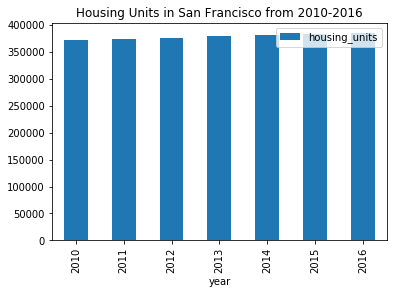

In [141]:
row_of_units= pn.Row(housing_units_per_year )
row_of_units

In [142]:
row_of_prices= pn.Row(average_gross_rent, average_sales_price )
row_of_prices

Row
    [0] Column
        [0] Column()
        [1] Row
            [0] HoloViews(Curve, name='interactive71403')
    [1] Column
        [0] Column()
        [1] Row
            [0] HoloViews(Curve, name='interactive71485')

In [143]:
row_of_neighborhood= pn.Row(neighborhood_d, top_most_expensive_neighborhoods )
row_of_neighborhood

Row
    [0] Column
        [0] Column()
        [1] Row
            [0] Str(None, name='interactive71252')
    [1] Column
        [0] Column()
        [1] Row
            [0] HoloViews(Bars, name='interactive71768')

In [144]:
row_of_parallel= pn.Row(parallel_categories, parallel_coordinates )
row_of_parallel

Row
    [0] Column
        [0] Column()
        [1] Row
            [0] Plotly(Figure, name='interactive71971')
    [1] Column
        [0] Column()
        [1] Row
            [0] Plotly(Figure, name='interactive71977')

In [145]:
row_of_map= pn.Row(neighborhood_map)
row_of_map

Row
    [0] Column
        [0] Column()
        [1] Row
            [0] Plotly(Figure, name='interactive71994')

In [146]:
price_column= pn.Column("Average prices in San Francisco", row_of_map,row_of_prices )
price_column

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71994')
    [2] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Curve, name='interactive71403')
        [1] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Curve, name='interactive71485')

In [147]:
SF_column= pn.Column("Real Estate in San Francisco", row_of_map,row_of_prices, row_of_parallel )
SF_column

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71994')
    [2] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Curve, name='interactive71403')
        [1] Column
            [0] Column()
            [1] Row
                [0] HoloViews(Curve, name='interactive71485')
    [3] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71971')
        [1] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71977')

In [148]:

Real_estate_dashboard= pn.Tabs(('San Francisco Real Estate', SF_column ),("Price Analysis", price_column), ("Statistical Plots",row_of_parallel))
Real_estate_dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71994')
        [2] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71403')
            [1] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71485')
        [3] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71971')
            [1] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71977')
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71994')
        [2] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71403')
            [1] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71485')
    [2] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71971')
        [1] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71977')

## Serve the Panel Dashboard

In [149]:
Real_estate_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71994')
        [2] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71403')
            [1] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71485')
        [3] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71971')
            [1] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71977')
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive71994')
        [2] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71403')
            [1] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Curve, name='interactive71485')
    [2] Row
        [0] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71971')
        [1] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive71977')